Data exploration and vizualization

In [38]:
#importing libraries

from google.colab import drive
import os
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.transforms as transforms
import torchvision
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
import tensorboard
from torch.utils.tensorboard import SummaryWriter
from collections import Counter




In [27]:
# Mount Google Drive
drive.mount('/content/drive')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [26]:

# Custom dataset class
class MyDataset(Dataset):
    def __init__(self, data_dir):
        self.data_dir = data_dir
        self.classes = os.listdir(data_dir)
        print(f"Classes: {self.classes}")  # Print class directories
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}
        self.images = []
        self.class_counts = {cls_name: 0 for cls_name in self.classes}

        for class_dir in self.classes:
            class_path = os.path.join(data_dir, class_dir)
            if os.path.isdir(class_path):
                image_files = [f for f in os.listdir(class_path) if f.endswith(('.jpg', '.jpeg', '.png'))]
                self.images.extend([(os.path.join(class_path, f), self.class_to_idx[class_dir]) for f in image_files])
                self.class_counts[class_dir] += len(image_files)

        self.transform = transforms.Compose([
            transforms.Resize((256, 256)),  # Resize to a fixed size
            transforms.ToTensor(),  # Convert to PyTorch tensor
        ])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image_path, label = self.images[idx]
        try:
            with open(image_path, 'rb') as file:
                image = Image.open(file)
                if image.mode != 'RGB':
                    image = image.convert('RGB')
                tensor_image = self.transform(image)
                return tensor_image, label
        except Exception as e:
            print(f"Error loading image {image_path}: {e}")
            raise ValueError('Path or data is wrong')



In [28]:
# Define paths to the datasets
train_path = "/content/drive/My Drive/content/train"
val_path = "/content/drive/My Drive/content/val"
test_path = "/content/drive/My Drive/content/test"

# Create instances of the custom dataset
train_dataset = MyDataset(train_path)
val_dataset = MyDataset(val_path)
test_dataset = MyDataset(test_path)



Classes: ['NORMAL', 'PNEUMONIA']
Classes: ['PNEUMONIA', 'NORMAL']
Classes: ['NORMAL', 'PNEUMONIA']


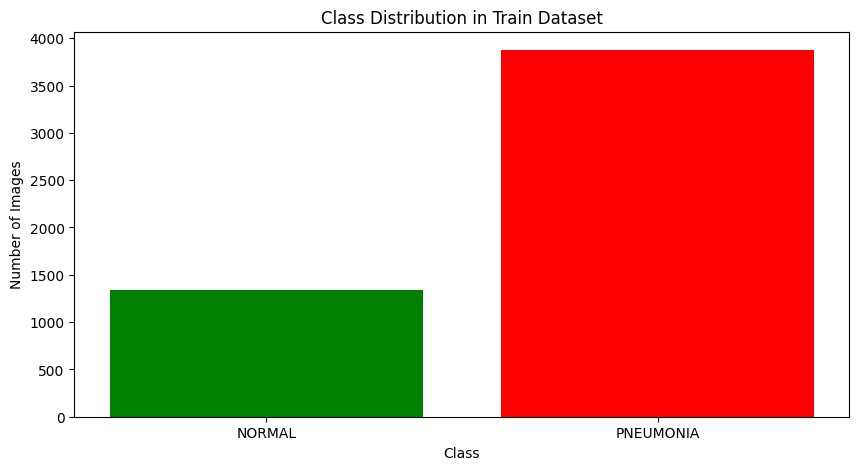

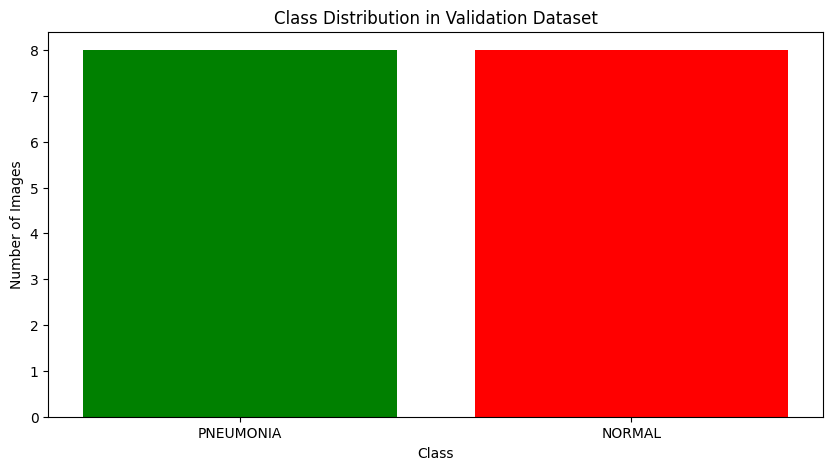

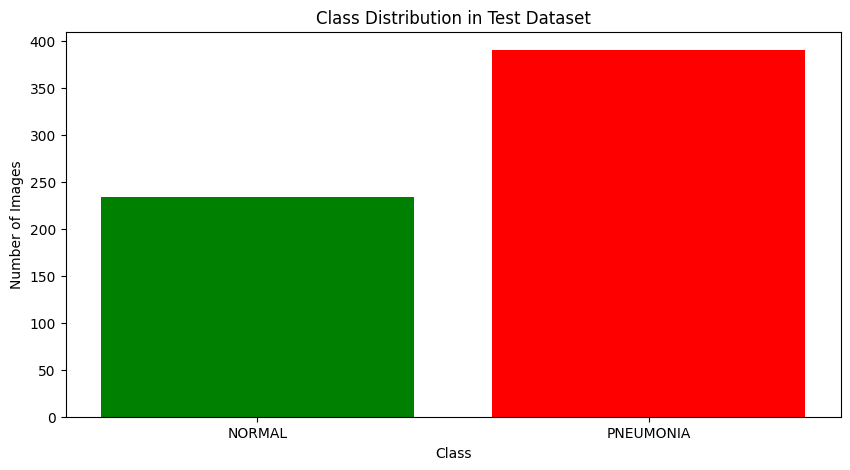

In [29]:


# Function to plot the class distribution
def plot_class_distribution(dataset, dataset_name):
    class_counts = dataset.class_counts
    classes = list(class_counts.keys())
    counts = list(class_counts.values())

    plt.figure(figsize=(10, 5))
    colors = ['green' if i % 2 == 0 else 'red' for i in range(len(classes))]
    plt.bar(classes, counts, color=colors)
    plt.xlabel('Class')
    plt.ylabel('Number of Images')
    plt.title(f'Class Distribution in {dataset_name} Dataset')
    plt.xticks(rotation=0)
    plt.show()

# Plot the class distribution for each dataset
plot_class_distribution(train_dataset, 'Train')
plot_class_distribution(val_dataset, 'Validation')
plot_class_distribution(test_dataset, 'Test')

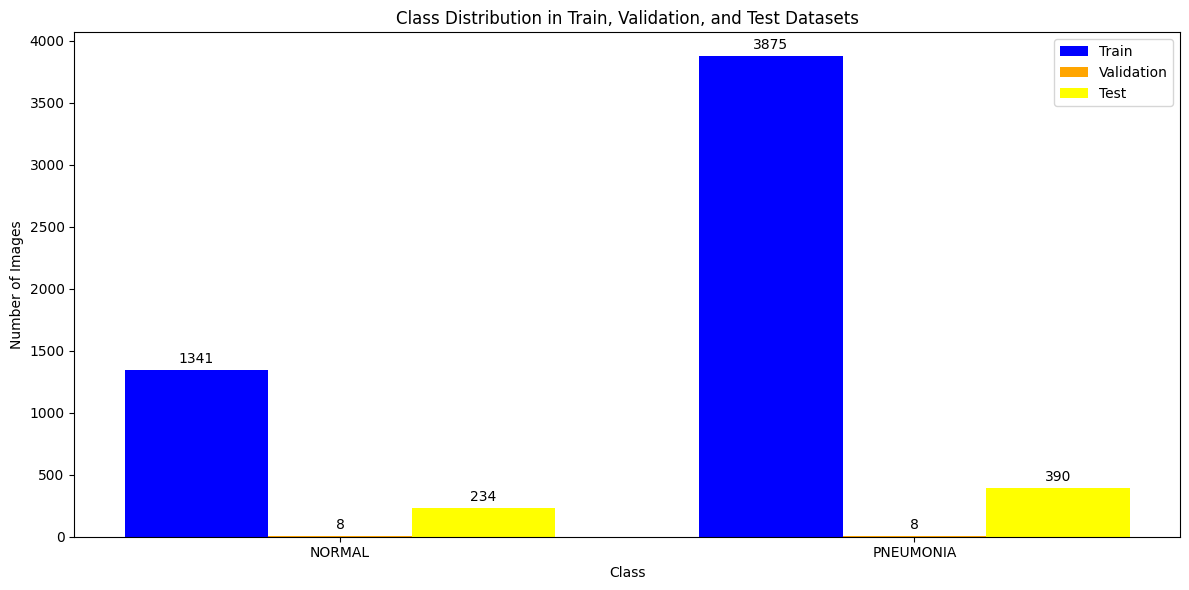

In [30]:
# Function to plot the combined class distribution
def plot_combined_class_distribution(train_dataset, val_dataset, test_dataset):
    classes = list(train_dataset.class_counts.keys())

    train_counts = [train_dataset.class_counts[cls] for cls in classes]
    val_counts = [val_dataset.class_counts[cls] for cls in classes]
    test_counts = [test_dataset.class_counts[cls] for cls in classes]

    x = np.arange(len(classes))  # the label locations
    width = 0.25  # the width of the bars

    fig, ax = plt.subplots(figsize=(12, 6))

    bars1 = ax.bar(x - width, train_counts, width, label='Train', color='blue')
    bars2 = ax.bar(x, val_counts, width, label='Validation',color='orange' )
    bars3 = ax.bar(x + width, test_counts, width, label='Test', color='yellow')


    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_xlabel('Class')
    ax.set_ylabel('Number of Images')
    ax.set_title('Class Distribution in Train, Validation, and Test Datasets')
    ax.set_xticks(x)
    ax.set_xticklabels(classes)
    ax.legend()

    # Add counts above the bars
    def add_counts(bars):
        for bar in bars:
            height = bar.get_height()
            ax.annotate(f'{height}',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')

    add_counts(bars1)
    add_counts(bars2)
    add_counts(bars3)

    fig.tight_layout()
    plt.show()

# Plot the combined class distribution for all datasets
plot_combined_class_distribution(train_dataset, val_dataset, test_dataset)

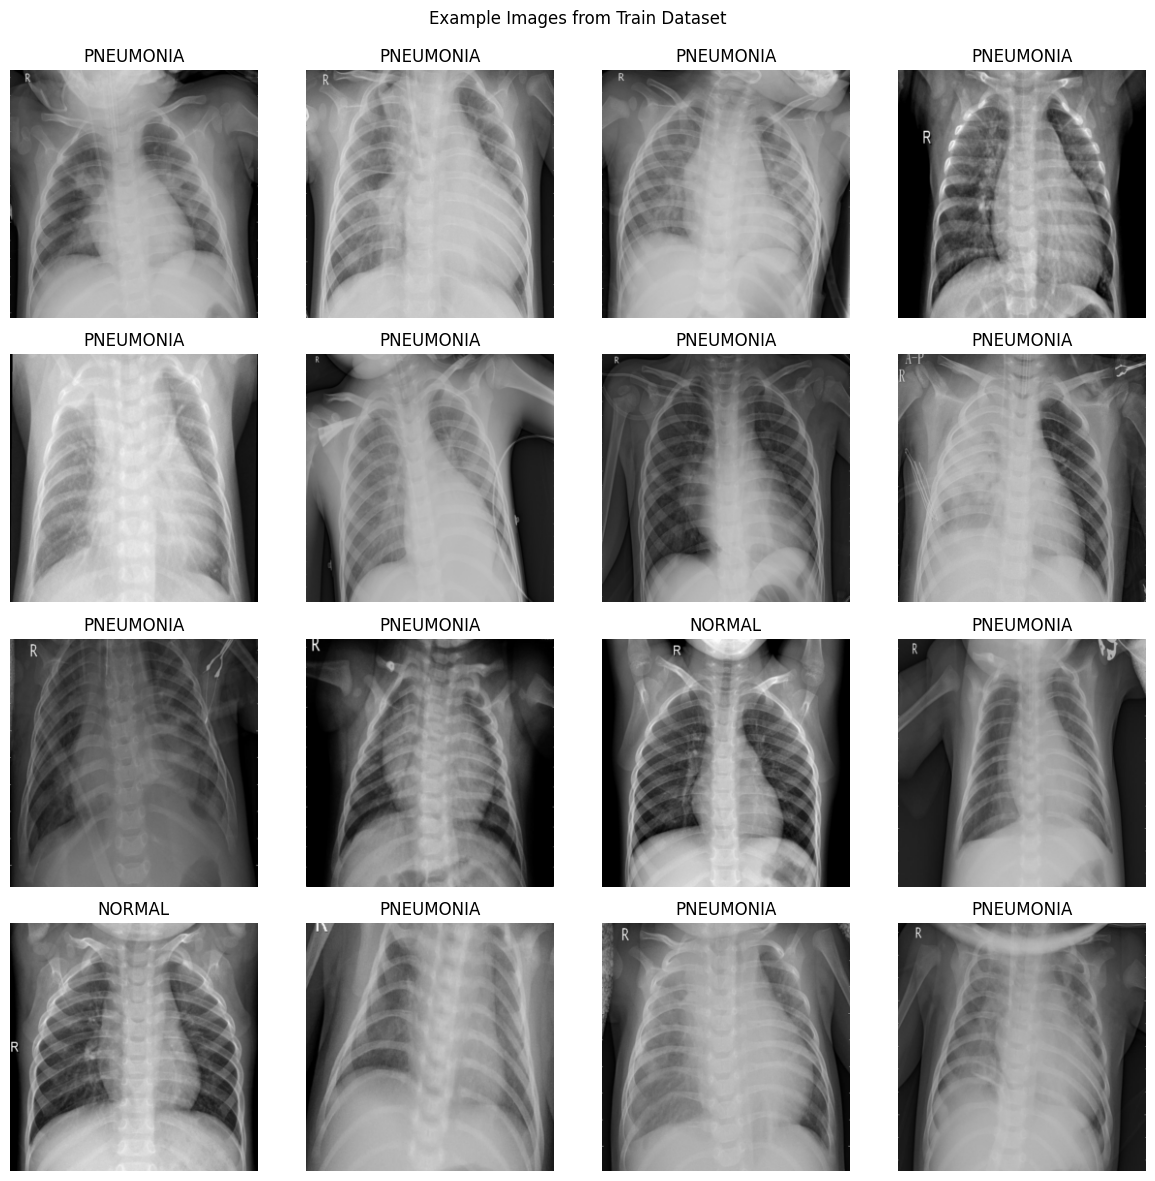

In [36]:
# Parameters for DataLoader
batch_size = 64 # optimal as we just want to vizualize and speed is priority
num_workers = 0  #


# DataLoader instances
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)


# Function to convert tensor to numpy array and display
def imshow(img, title=None):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    if title:
        plt.title(title)
    plt.axis('off')  # Hide axes
    plt.show()

# Visualize some test data in a grid with labels
def visualize_data_grid(loader, classes, num_images=16):
    dataiter = iter(loader)
    images, labels = next(dataiter)

    # Select a subset of images and labels
    images = images[:num_images]
    labels = labels[:num_images]

    # Plot the images in a grid
    fig, axes = plt.subplots(4, 4, figsize=(12, 12))
    fig.suptitle('Example Images from Train Dataset')

    for i in range(4):
        for j in range(4):
            idx = i * 4 + j
            if idx < num_images:
                img = images[idx]
                label = labels[idx]
                npimg = img.numpy()
                axes[i, j].imshow(np.transpose(npimg, (1, 2, 0)))
                axes[i, j].set_title(classes[label])
                axes[i, j].axis('off')  # Hide axes

    plt.tight_layout()
    plt.subplots_adjust(top=0.93)  # Adjust to make room for the title
    plt.show()

# Visualize some train data in a grid
visualize_data_grid(train_loader, train_dataset.classes)